# Tune density threshold to get desired DLA / HCD bias 

In [3]:
%pylab inline
# set the size of figures below
pylab.rcParams['figure.figsize'] = (10, 4)
from scipy.stats import norm

Populating the interactive namespace from numpy and matplotlib


We want to compute the threshold needed to get a given DLA bias. 

These notes are based on Font-Ribera & Miralda-Escudé (2012).

We will first look at a toy model to describe galaxy bias:
- The distribution of density fluctuations is described by a Gaussian $g$, with $<g>=0$ and $<g^2>=1$
- We choose a density threshold $\nu$, and those cells with $g>\nu$ will host a galaxy

In [4]:
show_plot=True
# this sets the threshold 
nu = 1.6
# probability density at the threshold
p_nu = norm.pdf(nu)
# density of galaxies is equal to the fraction of cells with density above the threshold 
mean = 1.0-norm.cdf(nu)
print('mean =',mean)

mean = 0.054799291699557995


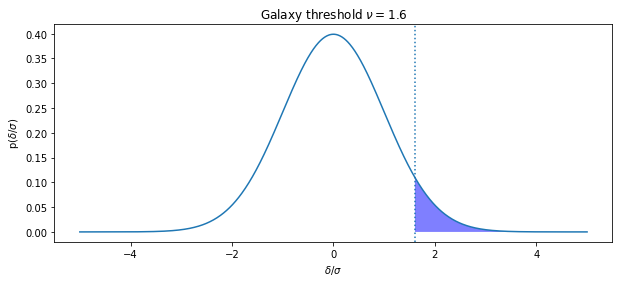

In [5]:
if show_plot:
    g = np.linspace(-5,5,1000)
    pdf = norm.pdf(g)
    plt.plot(g,pdf)
    above=(g>nu)
    plt.fill_between(g[above],0,pdf[above], facecolor='blue', alpha=0.5)
    plt.axvline(x=nu,ls=':')
    plt.xlabel('$\\delta/\\sigma$')
    plt.ylabel('p($\\delta/\\sigma$)')
    plt.title('Galaxy threshold $\\nu='+str(nu)+'$')
    plt.savefig('pdf_galaxy.pdf')

### Bias for a given threshold

We will use a slightly different notation than in Font-Ribera & Miralda-Escudé (2012). For instance, we use $\nu$ to refer to the threshold in the Normal random field $g$. Also, we want to study the bias of the peaks with respect to the correlation of $\delta = \sigma g$:

$\xi_\delta = < \delta_1 ~ \delta_2> = \sigma^2 < g_1 ~ g_2 > = \sigma^2 \rho$

We will first define the following function:

$B^2(\nu) = \frac{p(g = \nu)}{p^2(g>\nu)} \int_\nu^\infty dg ~ p(g) ~ g = \frac{p(g = \nu)}{p^2(g>\nu)} \frac{ e^{-\nu^2/2}} {\sqrt{2\pi}} = \left( \frac{p(g = \nu)}{p(g>\nu)} \right)^2$

and the correlations of the peaks will be:

$\xi_D = B^2(\nu) ~ \rho$

What we want is the correlation of the peaks to be:

$\xi_D(z) = b^2_D(z) ~ \xi(z) = b^2_D(z) ~ D^2(z) ~ \xi_0 = b^2_D(z) ~ D^2(z) ~ \sigma^2_0 ~ \rho$

So the relation is:

$B(\nu) = b_D(z) ~ D(z) ~ \sigma_0$

In [6]:
def bias_times_sigma(nu):
    # probability density at the threshold
    p_at_nu = norm.pdf(nu)
    # probability to be above the threshold
    p_above_nu = 1.0-norm.cdf(nu)
    return p_at_nu / p_above_nu

In [7]:
# explore different values of nu
nu=np.linspace(-3,3,100)
bsig_nu = bias_times_sigma(nu)

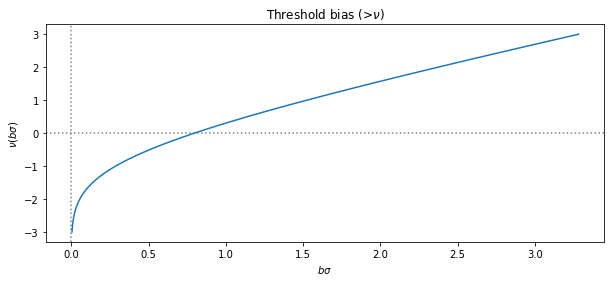

In [8]:
if show_plot:
    #plt.axvline(x=0.75,ls=':',color='gray') 
    plt.axvline(x=0,ls=':',color='gray')     
    plt.axhline(y=0,ls=':',color='gray') 
    plt.plot(bsig_nu,nu,label='galaxies')
    plt.ylabel('$\\nu(b \sigma)$')
    plt.xlabel(r'$b \sigma$')
    plt.title('Threshold bias (>$\\nu$)')
    plt.savefig('bias_threshold.pdf')

### Read $\sigma_0$ and $D(z)$ from CoLoRe to get $\nu(z)$

In [9]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt

In [10]:
#Open data file (test file with few quasars)
hdulist = fits.open('../example_data/raw_colore_1000/out_srcs_s1_0.fits')
cosmo = hdulist[4].data
D_z=cosmo['D']
z=cosmo['Z']

In [11]:
#Get density RMS at z=0
sigma_0=hdulist[4].header['SIGMA_G']
#Get density RMS as a function of z 
sigma_z = sigma_0 * D_z
#Assume DLA bias is constant at all redshifts
dla_bias=2.0

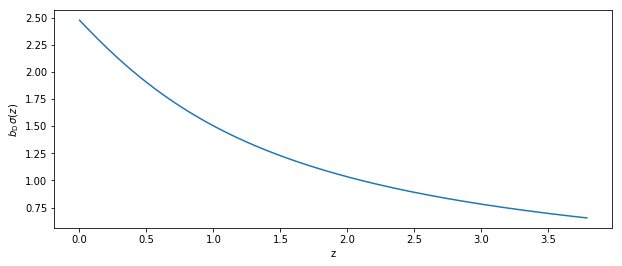

In [12]:
bsig_z=dla_bias * sigma_z
plt.plot(z,bsig_z)
#plt.xlim(2.0,3.5)
#plt.ylim(0.7,1.1)
plt.xlabel('z')
plt.ylabel(r'$b_{\rm{D}} \, \sigma(z)$')
plt.savefig('dla_bsig_z.pdf')

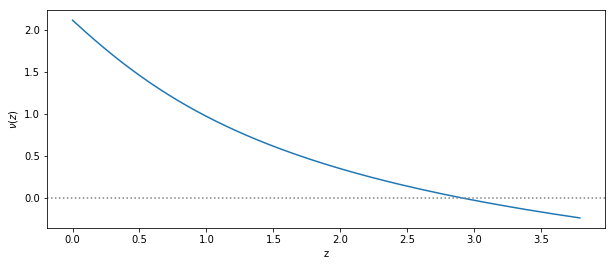

In [13]:
# compute threshold as a function of redshift
nu_z = np.interp(bsig_z,bsig_nu,nu)
plt.plot(z,nu_z)
#plt.xlim(2.0,3.5)
#plt.ylim(-0.2,0.5)
plt.xlabel('z')
plt.ylabel(r'$\nu(z)$')
#plt.axvline(x=2.3,ls=':',color='gray')     
plt.axhline(y=0,ls=':',color='gray') 
plt.savefig('dla_nu_z.pdf')

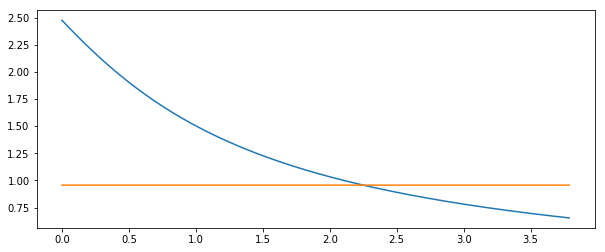

In [45]:
from scipy.interpolate import interp1d

def nu_of_bD(b):
    """ Compute the Gaussian field threshold for a given bias"""
    nu = np.linspace(-10,100,500) # Generous range to interpolate
    p_nu = norm.pdf(nu)
    galaxy_mean = 1.0-norm.cdf(nu)
    b_nu = np.zeros(nu.shape)
    b_nu[galaxy_mean!=0] = p_nu[galaxy_mean!=0]/galaxy_mean[galaxy_mean!=0]
    y = interp1d(b_nu,nu)
    return y(b)

y = interp1d(z,D_z)
b_D_sigma0 = dla_bias*D_z*sigma_0
alt_b_D_sigma0 = dla_bias*y(2.25)*sigma_0*np.ones(z.shape)
nu_arr = nu_of_bD(b_D_sigma0)

plt.plot(z,b_D_sigma0)
plt.plot(z,alt_b_D_sigma0)
plt.show()